# Exploratory Data Analysis (EDA)

This notebook explores the pig iron production data and thermal satellite indices.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import data_loader as dl

%matplotlib inline
plt.style.use('seaborn-v0_8')

## 1. Production data

In [2]:
# Set data path
DATA_PATH = "G:/My Drive/Documents/Applications/DBX Commodities 2025/Stage 2 Assignment/Data/Gijon"

# Load production data
production = dl.load_production_data(DATA_PATH)
print(f"Production data shape: {production.shape}")
print(f"Date range: {production.index.min()} to {production.index.max()}")
print(f"\nSummary statistics:")
production.describe()

Production data shape: (24, 1)
Date range: 2022-01-01 00:00:00 to 2023-12-01 00:00:00

Summary statistics:


,Value
count,24.000000
mean,267.750000
std,54.677911
min,182.000000
25%,204.500000
50%,286.000000
75%,308.750000
max,344.000000


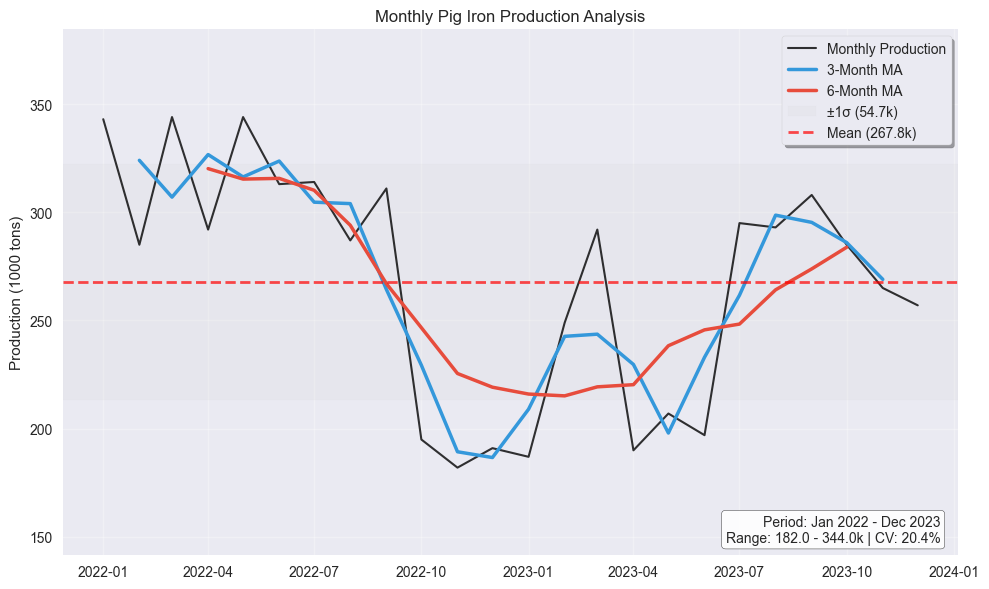

In [24]:
# Plot production over time
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate key statistics
mean_prod = production['Value'].mean()
std_prod = production['Value'].std()
ma_3 = production['Value'].rolling(3, center=True).mean()  # Rolling statistics
ma_6 = production['Value'].rolling(6, center=True).mean()

# Plot data
ax.plot(production.index, production['Value'], 'k-', linewidth=1.5, alpha=0.8, label='Monthly Production')
ax.plot(production.index, ma_3, color='#3498db', linewidth=2.5, label='3-Month MA')  # Bright blue
ax.plot(production.index, ma_6, color='#e74c3c', linewidth=2.5, label='6-Month MA')  # Red

# Add statistical context
ax.axhspan(mean_prod - std_prod, mean_prod + std_prod, alpha=0.15, color='lightgray', label=f'±1σ ({std_prod:.1f}k)')
ax.axhline(mean_prod, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean ({mean_prod:.1f}k)')

# Styling
ax.set_ylabel('Production (1000 tons)')
ax.set_title('Monthly Pig Iron Production Analysis')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add summary stats
cv = (std_prod / mean_prod) * 100
stats_text = f"Period: {production.index.min().strftime('%b %Y')} - {production.index.max().strftime('%b %Y')}\nRange: {min_val:.1f} - {max_val:.1f}k | CV: {cv:.1f}%"
ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Set y-limits with padding
y_min, y_max = production['Value'].min(), production['Value'].max()
y_range = y_max - y_min
ax.set_ylim(y_min - 0.25 * y_range, y_max + 0.25 * y_range)

plt.tight_layout()
plt.show()

## 2. Thermal index exploration

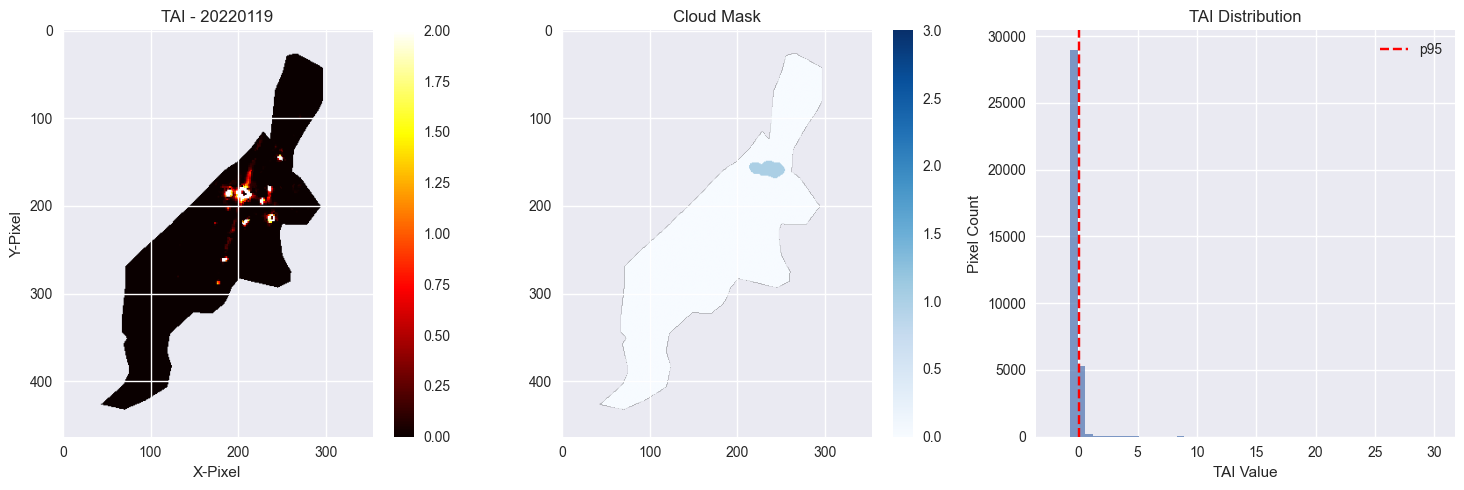

In [27]:
# Sample thermal data
sample_date = "20220119"
thermal_data = dl.load_thermal_index(DATA_PATH, "TAI", sample_date)
cloud_mask = dl.load_cloud_mask(DATA_PATH, sample_date)
perimeter_mask = dl.load_perimeter_mask(DATA_PATH)

if thermal_data is not None:
    # Visualise
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Thermal data
    masked_thermal = np.ma.masked_where(~perimeter_mask, thermal_data)
    im1 = axes[0].imshow(masked_thermal, cmap='hot', vmin=0, vmax=2)
    axes[0].set_xlabel('X-Pixel')
    axes[0].set_ylabel('Y-Pixel')
    axes[0].set_title(f'TAI - {sample_date}')
    plt.colorbar(im1, ax=axes[0])

    # Cloud mask
    if cloud_mask is not None:
        masked_cloud = np.ma.masked_where(~perimeter_mask, cloud_mask)
        im2 = axes[1].imshow(masked_cloud, cmap='Blues', vmin=0, vmax=3)
        axes[1].set_title('Cloud Mask')
        plt.colorbar(im2, ax=axes[1])

    # Histogram
    valid_pixels = thermal_data[perimeter_mask]
    axes[2].hist(valid_pixels, bins=50, alpha=0.7)
    axes[2].axvline(np.percentile(valid_pixels, 95), color='r',
                   linestyle='--', label='p95')
    axes[2].set_xlabel('TAI Value')
    axes[2].set_ylabel('Pixel Count')
    axes[2].set_title('TAI Distribution')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

## 3. Feature-Production correlation

c:\Users\mkers\Documents\GitHub\gijon-pig-iron-prediction\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3063: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mkers\Documents\GitHub\gijon-pig-iron-prediction\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3064: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


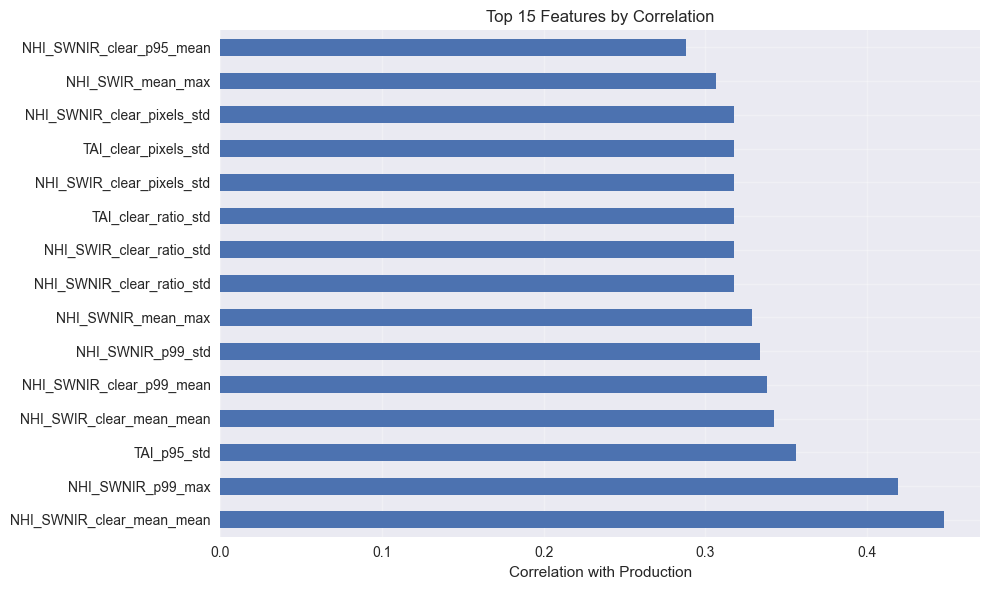

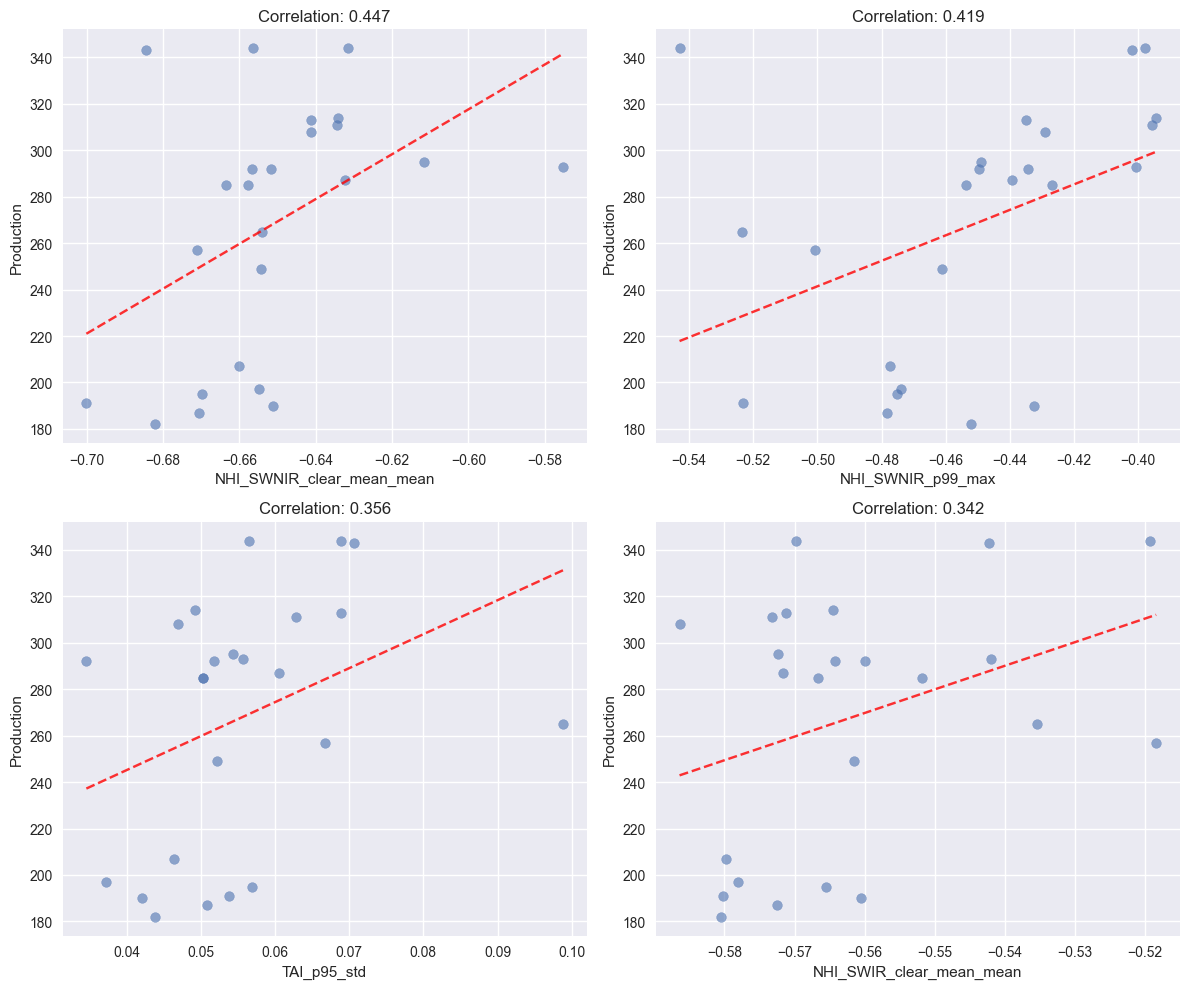

In [28]:
# Load pre-computed features if available
try:
    modeling_data = pd.read_csv('../results/csv/modeling_data.csv', index_col=0, parse_dates=True)

    # Calculate correlations
    feature_cols = [col for col in modeling_data.columns if col != 'Value']
    correlations = modeling_data[feature_cols].corrwith(modeling_data['Value']).sort_values(ascending=False)

    # Plot top correlations
    fig, ax = plt.subplots(figsize=(10, 6))
    top_features = correlations.head(15)
    top_features.plot(kind='barh', ax=ax)
    ax.set_xlabel('Correlation with Production')
    ax.set_title('Top 15 Features by Correlation')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Scatter plots of top features
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, (feature, corr) in enumerate(top_features.head(4).items()):
        ax = axes[i]
        ax.scatter(modeling_data[feature], modeling_data['Value'], alpha=0.6)
        ax.set_xlabel(feature)
        ax.set_ylabel('Production')
        ax.set_title(f'Correlation: {corr:.3f}')

        # Add trend line
        z = np.polyfit(modeling_data[feature], modeling_data['Value'], 1)
        p = np.poly1d(z)
        ax.plot(sorted(modeling_data[feature]), p(sorted(modeling_data[feature])),
                'r--', alpha=0.8)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("No modeling data found. Run the main pipeline first.")

## 4. Cloud coverage analysis

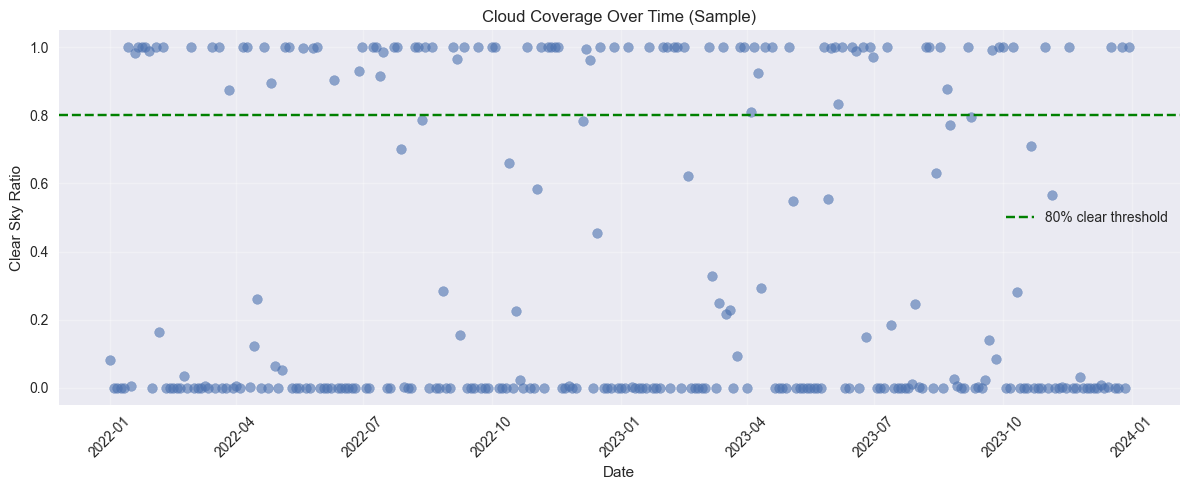

Average clear sky ratio: 35.88%
Days with >80% clear: 92


In [23]:
# Analyse cloud coverage impact
dates = dl.get_available_dates(DATA_PATH)
cloud_stats = []

# Sample 50 random dates
# sample_dates = np.random.choice(dates, min(50, len(dates)), replace=False)
sample_dates = dates

for date in sample_dates:
    cloud_mask = dl.load_cloud_mask(DATA_PATH, date)
    if cloud_mask is not None:
        clear_ratio = np.mean(cloud_mask[perimeter_mask] == 0)
        cloud_stats.append({
            'date': pd.to_datetime(date, format='%Y%m%d'),
            'clear_ratio': clear_ratio
        })

if cloud_stats:
    cloud_df = pd.DataFrame(cloud_stats).set_index('date')

    # Plot cloud coverage over time
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.scatter(cloud_df.index, cloud_df['clear_ratio'], alpha=0.6)
    ax.axhline(y=0.8, color='g', linestyle='--', label='80% clear threshold')
    ax.set_ylabel('Clear Sky Ratio')
    ax.set_xlabel('Date')
    ax.set_title('Cloud Coverage Over Time (Sample)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"Average clear sky ratio: {cloud_df['clear_ratio'].mean():.2%}")
    print(f"Days with >80% clear: {(cloud_df['clear_ratio'] > 0.8).sum()}")

## Summary

Key findings from EDA:
1. Production shows seasonal variation with lower values in Q4
2. Thermal indices have strong spatial patterns concentrated at industrial components
3. Cloud coverage varies significantly and affects data quality
4. High percentile thermal values (p95, p99) show strong correlation with production